### DTSA 5510 Unsupervised Algorithms in Machine Learning Final Project
Project Title: Predicting Sleep Quality Level: Supervised vs. Unsupervised Machine Learning Methods <br>
Date: 2023 Oct 28 <br>
Author: Tsai-Yun Li <br>
Course Lecturer: Geena Kim <br>
Organization: University of Colorado Boulder <br>
Github repo URL of this project: https://github.com/TsaiYunLi/ML2_Final_Project

### Table of Content
<br>1. Problem Description<br>
<br>2. Data Description and Data Cleaning<br>
<br>3. Exploratory Data Analysis (EDA)<br>
<br>4. Analysis: Model Building, Training, Testing, Evaluation <br>
<br>4.1 Data Splitting <br>
<br>4.2 Pure Supervised Approach: Support Vector Machine (SVM) <br>
<br>4.3 Unsupervised + Supervised Hybrid Approach 1: K-means Clustering + SVM <br>
<br>4.4 Unsupervised + Supervised Hybrid Approach 2: Agglomerative Hierarchical Clustering + SVM <br>
<br>5. Model Comparison<br>
<br>6. Conclusion and Discussion/Limitation<br>
<br>7. References

### 1. Problem Description
This project can be viewed as a continued project of the DTSA 5509 final project "Predicting Sleep Quality with Supervised Machine Learning Methods: A Case Study." It predicted whether the subject slept well or not, i.e., simplified the multi-level sleep quality level prediction problem to a binary class classification problem, using purely supervised machine learning approaches - logistic regression (LR), decision tree (DT), adaboost (AdaB), random forest (RF), and support vector machine (SVM) models. It was concluded that the SVM model performed the best, with an AUC of 0.72, an accuracy of 0.62, and an F1-score of 0.62. In this project, I want to cope with the multi-level sleep quality level prediction problem as a multi-class classification problem, as well as compare the purely supervised SVM model with hybrids of unsupervised clustering approaches and a supervised SVM classifier. In addition, I want to improve the data cleaning process by doing feature scaling and categorical variable encoding if applicable. I will also look into the possibility of overfitting in more detail.

Here are the models I will build in this project:
1. the SVM model: a purely supervised model
2. the KMeans_SVM model: a hybrid model of an unsupervised k-means clustering and a supervised SVM classifier, with hyperparameters to be tuned together
3. the Agg_SVM model: a hybrid model of an unsupervised agglomerative hierarchical clustering and a supervised SVM classifier, with hyperparameters to be tuned together

Note that I will build hybrid models with the unsupervised clustering approaches instead of other common unsupervised methods like PCA or NMF because of the nature of the dataset. Since the dataset (to be described in section 2) is not at all high dimensional, it is unnecessary to perform dimension reduction using PCA or NMF, which would risk overfitting and losing valuable information and interpretability. Since the dataset has very interpretable features that could potentially form clusters, clustering methods suit this project better. K-means clustering is chosen because that it is a simple and common clustering approach. While agglomerative hierarchical clustering has a higher computational complexity, it might capture more complex relations of the features. Thus, it is interesting to compare these two clustering methods. <br>

The questions I want to answer through this project are:
1. What are the statistical characteristics of the features? How can they be interpreted in context?
2. How well does a SVM model predict the subject's sleep quality level (multi-class classification; sleep quality level 0 to 10) compared to predicting the subject's sleep quality (binary class; slept well or not) in the previous project?
3. Which model, the purely supervised SVM model or the unsupervised-supervised hybrid Kmeans_SVM or Agg_SVM models, turns out to be the best one for this multi-class classification task? How well does the best-performing model predict the subject's sleep quality level?
4. Does any of the models overfit? How can I fix this?

In [1]:
# importing and loading the data
import pandas as pd

sleepdata  = pd.read_csv('https://raw.githubusercontent.com/TsaiYunLi/ML2_Final_Project/main/JohnsonSleepData_labeled.csv')
print('data size =', sleepdata.shape)
sleepdata.head()

data size = (46, 14)


,Date,Day,Bedtime,Waketime,Sleep Length,Bedtime Temp,Perceived Temp,Dream,Wake Freq,Waked by Wife,Wife Nocturia,Sleep Quality Level,Slept Well,Meta Data
0,5/6/22,Fri,11:00 PM,7:00 AM,8:00,26.3,Fine,Forgot,1.0,Yes,No,5.0,1.0,NaN
1,5/7/22,Sat,1:00 AM,8:30 AM,7:30,26.3,Fine,Forgot,1.0,Unsure,Yes,7.0,1.0,NaN
2,5/8/22,Sun,11:20 PM,7:30 AM,8:10,26.5,Hot,Forgot,0.0,No,Yes,4.0,-1.0,Drank too much water at night; Stomach a bit u...
3,5/9/22,Mon,1:00 AM,7:20 AM,6:20,26.5,Fine,Forgot,0.0,No,Yes,3.0,-1.0,NaN
4,5/10/22,Tue,11:00 PM,8:20 AM,9:20,26.7,Cold,Forgot,1.0,Unsure,Yes,5.0,1.0,NaN


### 2. Data Description and Data Cleaning
The sleep quality data is a tabulated dataset manually collected by the subject himself, intended as a reference for his doctor. I have got his full consent of using it in this public project.

As shown in the output above, the dataset contains 644 data points, which is made up of 46 rows for each day's sleep record, from 5 May 2022 to 20 June 2022, and 14 columns for 13 features that the subject believes might influence his sleep (not research based but purely out of his own sleep experience) and one added by myself to store the label 'Slept Well' indicating whether or not the subject slept well, i.e. 1 for positive and -1 for negative cases, which is used in the previous project as the target variable. This column will be dropped in this project, and the values in 'Sleep Quality Level' will be the target variable instead.

The features in the dataset are:
1. Date (m/d/yy): the date when the sleep instance took place; <br>                 
2. Day (Mon ~ Sun): the day when the sleep instance took place; <br> 
3. Bedtime (hh:mm AM/PM): the time when the subject went to bed; <br>  
4. Waketime (hh:mm AM/PM): the time when the subject woke up; <br> 
5. Sleep Length (h:mm): the length of sleep the subject got; <br> 
6. Bedtime Temp (degree Celsius): the bedroom temperature at Bedtime; <br>
Note that the bedroom was always air-conditioned at 26 degree Celsius. 'Bedtime Temp' is the measured before the air-conditioner was turned on. <br> 
7. Perceived Temp (Fine/Hot/Cold): how the subject physically felt about the bedroom temperature at Bedtime; <br> 
8. Dream (Forgot/Remeber/Unsure): wheteher or not the subject remember any dream at Waketime; <br>
9. Wake Freq (times): number of times the subject woke up during sleep; <br>
10. Waked by Wife (Yes/No/Unsure): whether or not the subject was waked by his wife during sleep; <br>
11. Wife Nocturia (Yes/No): whether or not the subject's wife experienced nocturia; <br>
12. Sleep Quality Level (0~10): the target varibale; how the subject self-evaluated his sleep qualtiy according to how fatigue he felt at Waketime, which is a 0 to 10 scale with 0 as the lowest score and 10 the highest; <br>
13. Slept Well (1, -1): the label of each record; <br>
For the binary class classification task in the previous project, the records are labeled with sleep quality level 5 to 9 as 1, i.e. positive, and sleep quality level 0 to 4 as -1, i.e. negative. Note that the subject never experienced a sleep quality level of 10. This feature would not be included in this project. <br>
14. Meta Data: additional qualitative information about the sleep that the subject thought might had an influence on his sleep experience <br>

In the following code sections, I will explore the dataset in detail to check for and handle useless data and missing data (null values). Techniques of feature scaling and categorical variable encoding using One-Hot encoding would be applied.

In [2]:
# checking for null values and each feature's data type
sleepdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 46 non-null     object 
 1   Day                  46 non-null     object 
 2   Bedtime              41 non-null     object 
 3   Waketime             41 non-null     object 
 4   Sleep Length         41 non-null     object 
 5   Bedtime Temp         41 non-null     float64
 6   Perceived Temp       41 non-null     object 
 7   Dream                41 non-null     object 
 8   Wake Freq            41 non-null     float64
 9   Waked by Wife        41 non-null     object 
 10  Wife Nocturia        41 non-null     object 
 11  Sleep Quality Level  41 non-null     float64
 12  Slept Well           41 non-null     float64
 13  Meta Data            16 non-null     object 
dtypes: float64(4), object(10)
memory usage: 5.2+ KB


In [3]:
# checking for each column's null values
print("column name, number of null values in each column before data cleaning:")
sleepdata.isna().sum()

column name, number of null values in each column before data cleaning:


Date                    0
Day                     0
Bedtime                 5
Waketime                5
Sleep Length            5
Bedtime Temp            5
Perceived Temp          5
Dream                   5
Wake Freq               5
Waked by Wife           5
Wife Nocturia           5
Sleep Quality Level     5
Slept Well              5
Meta Data              30
dtype: int64

In [4]:
# checking for each row's null values
print("row index, number of null values in each row before data cleaning:")
sleepdata.isna().sum(axis=1)

row index, number of null values in each row before data cleaning:


0      1
1      1
2      0
3      1
4      1
5      0
6     12
7     12
8     12
9      0
10     0
11     0
12     1
13     1
14     1
15     1
16     0
17     1
18     1
19     1
20     1
21    12
22     1
23     1
24     1
25     0
26     0
27     1
28     0
29     0
30     1
31     1
32     0
33    12
34     1
35     1
36     0
37     0
38     1
39     0
40     1
41     0
42     1
43     1
44     0
45     1
dtype: int64

From the output above, we can tell that except the first two columns, there are null values in the rest of the columns. Most features are objects, except for 'Bedtime Temp', 'Wake Freq', 'Sleep Quality Level', and 'Slept Well'.

Firstly, I decide to drop the column for 'Meta Data,' not only because it contains many null values but also for the fact that I am not going refer to it in my analysis. Secondly, I will drop the column 'Slept Well,' which stores the binary labels used in the previous project that is of no use here. Then, since all the null values are in the same 5 rows, which takes up only 11% of the data, I will drop these rows. Afterwards, I will perform some feature scaling and categorical feature encoding, including applying One-Hot Encoding on specific categorical features, as an improvement of the data cleaning process done in the previous project.

In [5]:
print("dataset shape before data cleaning:", sleepdata.shape)

dataset shape before data cleaning: (46, 14)


In [6]:
## removing specific data
# dropping 'Meta Data'
sleepdata = sleepdata.drop('Meta Data', axis=1)

# dropping 'Slept Well'
sleepdata = sleepdata.drop('Slept Well', axis=1)

# dropping the 5 rows with null values
sleepdata = sleepdata.dropna()

print(sleepdata.shape)

(41, 12)


In [7]:
## encoding categorical features, part 1
# substituting 'Day' values (Mon, Tues, Wed, Thurs, Fri, Sat, Sun) with number (1, 2, 3, 4, 5, 6, 7)
weekday_mapping = {'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thurs': 4, 'Fri': 5, 'Sat': 6, 'Sun': 7}
sleepdata['Day'] = sleepdata['Day'].map(weekday_mapping).astype(float)

# transforming the 'Bedtime' values from temporal format into numbers
# e.g. from 10:30 PM to 20.5; from 11:00 PM to 23.0; from 12:00 AM to 24.0; from 1:00 AM to 25.0
bedtime_numbers = []
nonNA_Bedtime = sleepdata['Bedtime'].notna()
for t in sleepdata['Bedtime'][nonNA_Bedtime]:
    time_parts = t.split(' ')
    hour, minute = map(int, time_parts[0].split(':'))
    if time_parts[1] == 'PM' and hour <= 11:
        hour += 12
    if time_parts[1] == 'AM' and hour == 12:
        hour += 12
    if time_parts[1] == 'AM' and 1 <= hour < 12:
        hour += 24
    fractional_hour = hour + minute / 60.0
    bedtime_numbers.append(fractional_hour)
sleepdata.loc[nonNA_Bedtime, 'Bedtime'] = bedtime_numbers

# transforming the 'Waketime' values from temporal format into numbers
# e.g. from 9:00 AM to 9.0, from 9:30 AM to 9.5
waketime_numbers = []
nonNA_Waketime = sleepdata['Waketime'].notna()
for t in sleepdata['Waketime'][nonNA_Waketime]:
    time_parts = t.split(' ')
    hour, minute = map(int, time_parts[0].split(':'))
    fractional_hour = hour + minute / 60.0
    waketime_numbers.append(fractional_hour)
sleepdata.loc[nonNA_Waketime, 'Waketime'] = waketime_numbers

# transforming the 'Sleep Length' values from temporal format into numbers
# e.g. from 8:00 to 8, from 7:30 to 7.5
sleeplength_numbers = []
nonNA_SleepLength = sleepdata['Sleep Length'].notna()
for t in sleepdata['Sleep Length'][nonNA_SleepLength]:
    time_parts = t.split(' ')
    hour, minute = map(int, time_parts[0].split(':'))
    fractional_hour = hour + minute / 60.0
    sleeplength_numbers.append(fractional_hour)
sleepdata.loc[nonNA_SleepLength, 'Sleep Length'] = sleeplength_numbers

In [8]:
## encoding categorical features, part 2
# converting the categorical 'Perceived Temp' from categorical to numerical data 0 or 1
# by applying the One-Hot encoding technique
# instead of substituting (Cold, Hot, Fine) with (1, 2, 3) as in the previous project
perctemp_encode = pd.DataFrame({'Perceived Temp': ['Cold', 'Hot', 'Fine']})
sleepdata = pd.concat([sleepdata, pd.get_dummies(sleepdata['Perceived Temp'], prefix='Perceived Temp')], axis=1)
sleepdata.drop('Perceived Temp', axis=1, inplace=True)

# converting the categorical 'Dream' from categorical to numerical data 0 or 1
# by applying the One-Hot encoding technique
# instead of substituting (Remember, Forgot) with (1, 2) as in the previous project
dream_encode = pd.DataFrame({'Dream': ['Remember', 'Forgot']})
sleepdata = pd.concat([sleepdata, pd.get_dummies(sleepdata['Dream'], prefix='Dream')], axis=1)
sleepdata.drop('Dream', axis=1, inplace=True)

# converting the categorical 'Waked by Wife' from categorical to numerical data 0 or 1
# by applying the One-Hot encoding technique
# instead of substituting (Unsure, Yes, No) with (1, 2, 3) as in the previous project
wbf_encode = pd.DataFrame({'Waked by Wife': ['Unsure', 'Yes', 'No']})
sleepdata = pd.concat([sleepdata, pd.get_dummies(sleepdata['Waked by Wife'], prefix='Waked by Wife')], axis=1)
sleepdata.drop('Waked by Wife', axis=1, inplace=True)

# converting the categorical 'Wife Nocturia' from categorical to numerical data 0 or 1
# by applying the One-Hot encoding technique
# instead of substituting (Yes, No) with (1, 2) as in the previous project
wn_encode = pd.DataFrame({'Wife Nocturia': ['Yes', 'No']})
sleepdata = pd.concat([sleepdata, pd.get_dummies(sleepdata['Wife Nocturia'], prefix='Wife Nocturia')], axis=1)
sleepdata.drop('Wife Nocturia', axis=1, inplace=True)

Even though applying One-Hot encoding on the features above added 10 binary columns filled with quite some zeros and increases the sparsity of the dataset, since the dataset with its null values removed is small and very dense, this would not be too much of a problem. Besides, compared to the randomly assignmed numbers to these categorical features in the previous project which could be misleadingly interpreted as their weights, the benefit of One-Hot encoding's logical labeling (0 or 1) overweights the sparsity issue. 

In [9]:
## double checking if all the null values are eliminated
# checking for each column's null values
print("column name, number of null values in each column after data cleaning:", sleepdata.isna().sum(), "\n")

# checking for each row's null values
print("row index, number of null values in each row after data cleaning:", sleepdata.isna().sum(axis=1))

column name, number of null values in each column after data cleaning: Date                    0
Day                     0
Bedtime                 0
Waketime                0
Sleep Length            0
Bedtime Temp            0
Wake Freq               0
Sleep Quality Level     0
Perceived Temp_Cold     0
Perceived Temp_Fine     0
Perceived Temp_Hot      0
Dream_Forgot            0
Dream_Remember          0
Waked by Wife_No        0
Waked by Wife_Unsure    0
Waked by Wife_Yes       0
Wife Nocturia_No        0
Wife Nocturia_Yes       0
dtype: int64 

row index, number of null values in each row after data cleaning: 0     0
1     0
2     0
3     0
4     0
5     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
dtype: int64


In [10]:
print("data shape after data cleaning:")
sleepdata.shape

data shape after data cleaning:


(41, 18)

In [11]:
print("data info after data cleaning:")
sleepdata.info()

data info after data cleaning:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 0 to 45
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  41 non-null     object 
 1   Day                   41 non-null     float64
 2   Bedtime               41 non-null     float64
 3   Waketime              41 non-null     float64
 4   Sleep Length          41 non-null     float64
 5   Bedtime Temp          41 non-null     float64
 6   Wake Freq             41 non-null     float64
 7   Sleep Quality Level   41 non-null     float64
 8   Perceived Temp_Cold   41 non-null     uint8  
 9   Perceived Temp_Fine   41 non-null     uint8  
 10  Perceived Temp_Hot    41 non-null     uint8  
 11  Dream_Forgot          41 non-null     uint8  
 12  Dream_Remember        41 non-null     uint8  
 13  Waked by Wife_No      41 non-null     uint8  
 14  Waked by Wife_Unsure  41 non-null     uint8  

In [12]:
print("data head after data cleaning:")
sleepdata.head()

data head after data cleaning:


,Date,Day,Bedtime,Waketime,Sleep Length,Bedtime Temp,Wake Freq,Sleep Quality Level,Perceived Temp_Cold,Perceived Temp_Fine,Perceived Temp_Hot,Dream_Forgot,Dream_Remember,Waked by Wife_No,Waked by Wife_Unsure,Waked by Wife_Yes,Wife Nocturia_No,Wife Nocturia_Yes
0,5/6/22,5.0,23.000000,7.000000,8.000000,26.3,1.0,5.0,0,1,0,1,0,0,0,1,1,0
1,5/7/22,6.0,25.000000,8.500000,7.500000,26.3,1.0,7.0,0,1,0,1,0,0,1,0,0,1
2,5/8/22,7.0,23.333333,7.500000,8.166667,26.5,0.0,4.0,0,0,1,1,0,1,0,0,0,1
3,5/9/22,1.0,25.000000,7.333333,6.333333,26.5,0.0,3.0,0,1,0,1,0,1,0,0,0,1
4,5/10/22,2.0,23.000000,8.333333,9.333333,26.7,1.0,5.0,1,0,0,1,0,0,1,0,0,1


##### Data Cleaning Summary:
1. useless columns 'Meta Data'and 'Slept Well' are removed
2. 5 rows of of data full of null values are removed
3. no useless or missing data left
4. columns 'Perceived Temp,' 'Dream,' 'Waked by Wife,' and 'Wife Nocturia' are dropped and replaced by the 10 binary columns generated by One-Hot encoding, namely 'Perceived Temp_Cold,' 'Perceived Temp_Fine,' 'Perceived Temp_Hot,' 'Dream_Forgot,' 'Dream_Remember,' 'Waked by Wife_No,' 'Waked by Wife_Unsure,' 'Waked by Wife_Yes,' 'Wife Nocturia_No,' and 'Wife Nocturia_Yes.'

Note that I decided to not to scale the features now because I want to retain these features' contextual meaning which should provide more insight for analysis. For example, 'Day' has a range of 1 to 7, representing the seven days in a week like '1' representing 'Monday.' The numerical values for 'Bedtime' and 'Waketime' both represents the actual time the subject went to bed and woke up. Similarly, 'Waketime,' 'Sleep Length', 'Bedtime Temp,' and 'Wake Freq' all have interpretable units. It would be too much of an information loss if they are removed. I will scale the features after data splitting, which is after EDA and before modeling, to improve model performance. <br>

5. contains 18 features: only 'Date' remains as a string object, others are all converted into float64 or uint8 numerical items for the convenience of further statistical/graphical analysis and modelling
6. contains 41 rows and 18 columns

### 3. Exploratory Data Analysis (EDA)
In this section, I will explore the dataset further and prepare it ready for modelling. First, I will compute simple summary statistics and graph the distribution of the features to get an impression of the main characteristics and patterns of the data. Then check for and handle outliers and correlated features to reduce overfitting. Finally, I will find out if the dataset is balanced or not, which would influence my choice of model evaltion metrics later.

In [13]:
## getting a rough statistic idea of the features
# simple statistics of each feature
sleepdata.describe()

,Day,Bedtime,Waketime,Sleep Length,Bedtime Temp,Wake Freq,Sleep Quality Level,Perceived Temp_Cold,Perceived Temp_Fine,Perceived Temp_Hot,Dream_Forgot,Dream_Remember,Waked by Wife_No,Waked by Wife_Unsure,Waked by Wife_Yes,Wife Nocturia_No,Wife Nocturia_Yes
count,41.000000,41.000000,41.000000,41.000000,41.00000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,4.000000,23.654472,7.928862,8.274390,27.60000,0.439024,4.170732,0.219512,0.731707,0.048780,0.926829,0.073171,0.756098,0.073171,0.170732,0.097561,0.902439
std,2.144761,0.886935,0.688083,1.035187,1.44931,1.073517,2.143624,0.419058,0.448575,0.218085,0.263652,0.263652,0.434769,0.263652,0.380949,0.300406,0.300406
min,1.000000,22.000000,6.000000,5.166667,25.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,23.000000,7.500000,7.833333,26.30000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,4.000000,23.500000,8.000000,8.500000,27.30000,0.000000,5.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,6.000000,24.166667,8.500000,9.000000,29.00000,1.000000,5.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,7.000000,26.333333,9.166667,9.916667,30.10000,6.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### The mean of each numerical feature and their contextual interpretation:
1. Day (4.00): Thursday, not meaningful for analysis; 
2. Bedtime (23.65): the subject went to bed at 11:39 PM in average; 
3. Waketime (7.93): the subject woke up at 7:56 AM in average;
4. Sleep Length (8.27): the subject slept for 8 hours 16 minutes per night in average; 
5. Bedtime Temp (27.60): the room temperature was 27.6 degree Celsius per night in average; 
6. Wake Freq (0.44): the subject woke up once per night in average; 
7. Sleep Quality Level (4.17): the subject experienced a sleep quality of level 4 in average

In [14]:
one_hot_encoded_columns = sleepdata.columns[-10:].tolist()
for col in one_hot_encoded_columns:
    print(f"Frequency count for {col}: {sleepdata[col].sum()}")

Frequency count for Perceived Temp_Cold: 9
Frequency count for Perceived Temp_Fine: 30
Frequency count for Perceived Temp_Hot: 2
Frequency count for Dream_Forgot: 38
Frequency count for Dream_Remember: 3
Frequency count for Waked by Wife_No: 31
Frequency count for Waked by Wife_Unsure: 3
Frequency count for Waked by Wife_Yes: 7
Frequency count for Wife Nocturia_No: 4
Frequency count for Wife Nocturia_Yes: 37


In [15]:
print("Perceived Temp_Fine takes up", 30/41*100, "percent of all Perceived Temp")
print("Perceived Dream_Forgot takes up", 38/41*100, "percent of all Dream")
print("Perceived Waked by Wife_No takes up", 31/41*100, "percent of all Waked by Wife")
print("Perceived Waked by Wife Nocturia_Yes takes up", 37/41*100, "percent of all Wife Nocturia")

Perceived Temp_Fine takes up 73.17073170731707 percent of all Perceived Temp
Perceived Dream_Forgot takes up 92.6829268292683 percent of all Dream
Perceived Waked by Wife_No takes up 75.60975609756098 percent of all Waked by Wife
Perceived Waked by Wife Nocturia_Yes takes up 90.2439024390244 percent of all Wife Nocturia


##### The most frequent categorical features and their frequency percentage:
The categorical features mentioned here are the ones converted by One-Hot encoding.
1. Perceived Temp_Fine: about 73%; 
2. Dream_Forgot: about 93%; 
3. Waked by Wife_No: about 76%; 
4. Wife Nocturia_Yes: about 90% 

This reflects the fact that most of the time:
1. The subject perceived the room temperature as fine when he went to bed.
2. He forgot his dream when he woke up in the morning.
3. He was not waked by his wife during sleep.
4. His wife did usually experience nocturia during his sleep, which probably did not wake him, not knowing if it disturbed his sleep or not.

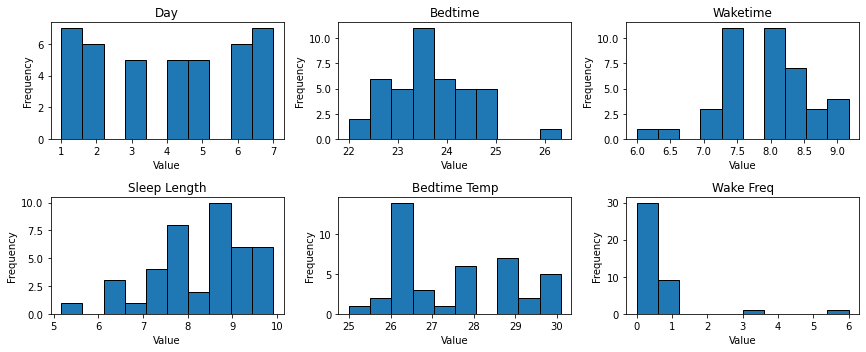

In [16]:
## understanding the distribution of the numerical features
# except the target variable "Sleep Quality Level"
# creating a histogram (2x3 grid) for their distributions
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 3, figsize=(12, 5))
axs = axs.ravel()  
selected_columns = sleepdata.iloc[:, 1:7]

for i, col in enumerate(selected_columns.columns):
    axs[i].hist(selected_columns[col], bins=10, edgecolor='black')
    axs[i].set_title(col)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

##### The shape of each feature's distribution:
From the histograms above, we can tell that:
1. features with a roughly bell-shaped distribution (i.e. roughly normally distributed): 'Bedtime,' 'Waketime,' and 'Sleep Length,' indicating a rather even distribution around the average of the distribution, which is good

2. feature with an apparently right-skewed distribution: 'Wake Freq,' indicating that the majority of its value is rather small; that is, the subject was not frequently waked by his wife during his sleep

3. features with a roughly m-shaped/bimodal distribution: 'Day,' and 'Bedtime Temp,' indicating that these two features are more or less concentrated in two modes

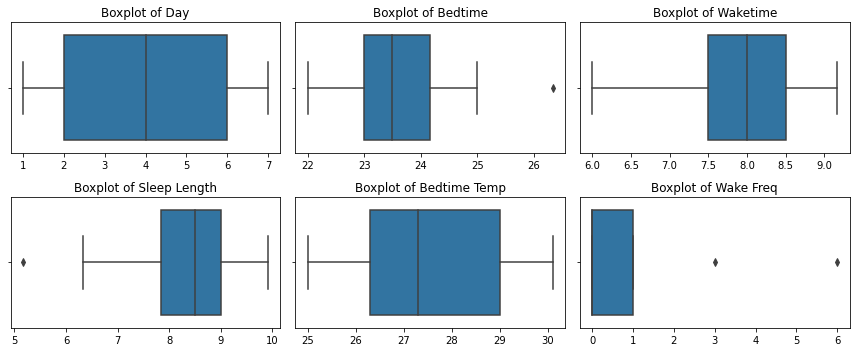

In [17]:
## checking for outliers in the numerical features
# except the target variable "Sleep Quality Level"
# creating a boxplot (2x3 grid) for their distributions
import seaborn as sns
fig, axes = plt.subplots(2, 3, figsize=(12, 5))
axes = axes.ravel()

for i, feature in enumerate(selected_columns.columns):
    ax = axes[i]
    sns.boxplot(data=sleepdata, x=feature, ax=ax)
    ax.set_title(f'Boxplot of {feature}')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

##### Found Outliers: 
From the boxplots above, we can tell that there are outliers in the data in the following features:
1. 'Bedtime': outliers are values > 26; <br>
2. 'Sleep Length': outliers are values < 6; <br>
3. 'Wake Freq': outliers are values > 1

I will locate the rows with the outliers for each of these features to inspect them in context and then decide how to handle them.

In [18]:
# locating the outliers
BT_above_26 = sleepdata['Bedtime'] > 26
BT_outliers = sleepdata[BT_above_26]
print("Bedtime outlier row:", BT_outliers, "\n")

SL_under_6 = sleepdata['Sleep Length'] < 6
SL_outliers = sleepdata[SL_under_6]
print("Sleep Length outlier row:", SL_outliers, "\n")

WFreq_above_1 = sleepdata['Wake Freq'] > 1
WFreq_outliers = sleepdata[WFreq_above_1]
print("Wake Freq outlier row:", WFreq_outliers)

Bedtime outlier row:        Date  Day    Bedtime  Waketime  Sleep Length  Bedtime Temp  Wake Freq  \
44  6/19/22  7.0  26.333333       7.5      5.166667          29.8        0.0   

    Sleep Quality Level  Perceived Temp_Cold  Perceived Temp_Fine  \
44                  5.0                    1                    0   

    Perceived Temp_Hot  Dream_Forgot  Dream_Remember  Waked by Wife_No  \
44                   0             1               0                 1   

    Waked by Wife_Unsure  Waked by Wife_Yes  Wife Nocturia_No  \
44                     0                  0                 0   

    Wife Nocturia_Yes  
44                  1   

Sleep Length outlier row:        Date  Day    Bedtime  Waketime  Sleep Length  Bedtime Temp  Wake Freq  \
44  6/19/22  7.0  26.333333       7.5      5.166667          29.8        0.0   

    Sleep Quality Level  Perceived Temp_Cold  Perceived Temp_Fine  \
44                  5.0                    1                    0   

    Perceived Temp_Hot 

In [19]:
## handling outliers of Bedtime and Sleep Length
# removing record for date 6/19/22, 5/11/22, and 6/11/22
print("number of rows before removing this row:", len(sleepdata))
outlier_rows = sleepdata['Date'].isin(['6/19/22', '5/11/22', '6/11/22'])
sleepdata = sleepdata[~outlier_rows]
print("number of rows after removing this row:", len(sleepdata))

number of rows before removing this row: 41
number of rows after removing this row: 38


##### Handled the Outliers:
After close inspection of the outliers, I discarded the row with sleep record for 'Date' 6/19/22, because it contains both the outliers of features 'Bedtime' and 'Sleep Length,' indicating that it deviates from an average night's sleep experience too much to be considered in the data. I also removed the row with sleep record for 'Date' '5/11/22' and '6/11/22' because they contain the only two outliers in 'Wake Freq.'

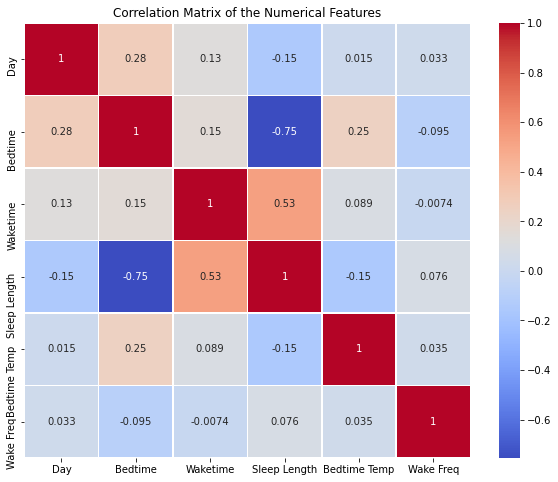

In [20]:
## checking for multicollinearity
# creating a heatmap for the correlation matrix of the numerical features 
# except the target variable "Sleep Quality Level"
corr_matrix = selected_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of the Numerical Features')
plt.show()

In [21]:
## handling multicollinearity
# removing feature 'SLeep Length'
sleepdata = sleepdata.drop('Sleep Length', axis=1)

##### Found and Handled Multicollinearity:

Multicollinearity is found from the correlation matrix above:
1. features that exhibit a relatively strong, positive, linear correlation:
'Waketime' and 'Sleep Length' (0.53), which is reasonable and expected, because 'Sleep Length' was a linear combination of 'Waketime' and 'Bedtime'; <br>

2. features that exhibit a relatively strong, negative, linear correlation:
'Bedtime' and 'Sleep Length' (-0.75), which is reasonable and expected as well, because 'Sleep Length' was a linear combination of 'Waketime' and 'Bedtime.' <br>

Therefore I handled the issue of multicollinearity by removing 'Sleep Length,' the feature relatively strongly correlated with both 'Bedtime' and 'Waketime.

number of samples for each class: 5.0    14
3.0     7
1.0     6
7.0     3
8.0     2
4.0     2
2.0     1
0.0     1
6.0     1
9.0     1
Name: Sleep Quality Level, dtype: int64
class ratios: 5.0    0.368421
3.0    0.184211
1.0    0.157895
7.0    0.078947
8.0    0.052632
4.0    0.052632
2.0    0.026316
0.0    0.026316
6.0    0.026316
9.0    0.026316
Name: Sleep Quality Level, dtype: float64


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

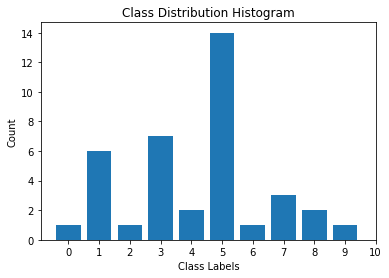

In [22]:
## checking if the dataset is balanced or imbalanced
# computing number of samples for each class and class ratio
class_labels = sleepdata["Sleep Quality Level"]
class_counts = class_labels.value_counts()
class_ratios = class_counts/class_counts.sum()
print("number of samples for each class:", class_counts)
print("class ratios:", class_ratios)

# creating class distribution histogram
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Class Distribution Histogram')
plt.xticks(ticks=range(0, 11), labels=range(0, 11))
plt.tight_layout

In [23]:
class_counts = sleepdata['Sleep Quality Level'].value_counts()
print(f"class_counts:", class_counts)

class_counts: 5.0    14
3.0     7
1.0     6
7.0     3
8.0     2
4.0     2
2.0     1
0.0     1
6.0     1
9.0     1
Name: Sleep Quality Level, dtype: int64


##### Imbalanced Data:
From the computed class count and the skewed class ratio, we can tell that this dataset is imbalanced.

In [24]:
# summary statistics of the finalized dataset
print("data info after EDA:")
sleepdata.info()

print("data shape after EDA:")
sleepdata.shape

data info after EDA:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 45
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  38 non-null     object 
 1   Day                   38 non-null     float64
 2   Bedtime               38 non-null     float64
 3   Waketime              38 non-null     float64
 4   Bedtime Temp          38 non-null     float64
 5   Wake Freq             38 non-null     float64
 6   Sleep Quality Level   38 non-null     float64
 7   Perceived Temp_Cold   38 non-null     uint8  
 8   Perceived Temp_Fine   38 non-null     uint8  
 9   Perceived Temp_Hot    38 non-null     uint8  
 10  Dream_Forgot          38 non-null     uint8  
 11  Dream_Remember        38 non-null     uint8  
 12  Waked by Wife_No      38 non-null     uint8  
 13  Waked by Wife_Unsure  38 non-null     uint8  
 14  Waked by Wife_Yes     38 non-null     uint8  
 15  Wife

(38, 17)

##### EDA Summary:
1. computed feature simple statistics;
2. graphed feature distribution: Note that 'Wake Freq' is right-skewed, which visualized the fact that the majority of its values is small;
3. removed outliers: removed row for 'Date' 6/19/22, 5/11/22, and 6/11/22;
4. found correlated features: 'Waketime' and 'Sleep Length' (0.53), 'Bedtime' and 'Sleep Length' (-0.75); <br>
5. handled multicolinearity: removed 'Sleep Length'; 
6. class label distribution: imbalanced, which should be handled during model construction; <br>
7. finalized dataset data shape: 38 rows * 17 columns; <br>
8. finalized feature selection: <br>
one feature for the referece of each sleep instance: 'Date'<br>
one feature as the output variable y (i.e. the prediction label): 'Slept Quality Level' <br>
the rest of the fifteen features as the input variable X: 'Day,' 'Bedtime,' 'Waketime,' 'Bedtime Temp,' 'Wake Freq,' 'Perceived Temp_Cold' 'Perceived Temp_Fine,' 'Perceived Temp_Hot,' 'Dream_Forgot,' 'Dream_Remember,' 'Waked by Wife_No,' 'Waked by Wife_Unsure,' 'Waked by Wife_Yes,' 'Wife Nocturia_No,' 'Wife Nocturia_Yes' <br>

After doing data splitting in the next section, I will scale the input features in X, because SVM is sensitive to feature scales. If applicable, I will and perform a resampling technique, SMOTE, on X_train and y_train to mitigate the impact of imbalance data and improve model performance. That is, ideally, X_train_smote and y_train_smote will be used to build the model so that it will learn from the SMOTE-generated, synthesized, balanced dataset without favoring the majority class; while, X_train_scaled and X_test_scaled will be used to test the model so that I can evaluate its performance on the real, imbalanced dataset.

### 4. Analysis: Model Building, Training, Testing, Evaluation
In this section, I will build the three models described in section, namely the purely supervised SVM, and the unsupervised-supervised hybrid Kmeans_SVM, and Agg_SVM models. I will try to optimize their performance by doing hyperparameter tuning and gridsearch to find their best parameters. The models will be trained using the training dataset X_train  and X_test, and further tested using the test dataset y_test. Finally, I will evaluate the models using several evaluation metrics, including accuracy score, f1-score, and rsme. AUC score is not computed here since y_test does not contain all the class labels because the dataset is small and imbalanced. <br>

As mentioned before, I will try to do feature scaling and resampling (using SMOTE) after data splitting to mitigate the impact of the imbalance, small dataset on model performance.

##### 4.1 Data Splitting

In [25]:
## splitting the modified dataset into a training set (90%) and a testing set (20%)
# getting a smaller test set because the dataset is small
from sklearn.model_selection import train_test_split
import numpy as np

X = sleepdata[['Day', 'Bedtime', 'Waketime', 'Bedtime Temp', 'Wake Freq', 
               'Perceived Temp_Cold', 'Perceived Temp_Fine', 'Perceived Temp_Hot', 'Dream_Forgot', 'Dream_Remember', 
               'Waked by Wife_No', 'Waked by Wife_Unsure', 'Waked by Wife_Yes', 'Wife Nocturia_No', 'Wife Nocturia_Yes']]
y = sleepdata['Sleep Quality Level'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, 
                                                    random_state=1234) #, stratify=y)

print("data shape:", sleepdata.shape, "\n")
print("X_train shape:", X_train.shape, " X_train datatype:", type(X_train))
print("X_test shape:", X_test.shape, " y_train datatype:", type(y_train))
print("y_train shape:", y_train.shape, " X_test datatype:", type(X_test))
print("y_test shape:", y_test.shape, " y_test datatype:", type(y_test), "\n")

print("unique classes in y_train:", np.unique(y_train))
print("unique classes in y_test:", np.unique(y_test))
print("y_test does not contain all the class labels because the dataset is imbalanced.")

data shape: (38, 17) 

X_train shape: (30, 15)  X_train datatype: <class 'pandas.core.frame.DataFrame'>
X_test shape: (8, 15)  y_train datatype: <class 'numpy.ndarray'>
y_train shape: (30,)  X_test datatype: <class 'pandas.core.frame.DataFrame'>
y_test shape: (8,)  y_test datatype: <class 'numpy.ndarray'> 

unique classes in y_train: [0. 1. 3. 4. 5. 6. 7. 8. 9.]
unique classes in y_test: [1. 2. 3. 4. 5. 7.]
y_test does not contain all the class labels because the dataset is imbalanced.


In [26]:
## scaling X_train and X_test because SVM is sensitive to feature scales
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### Note that:
However, after a few iterations and modifications, SMOTE turned out to be not applicable here, since a few minority classes has only 1 instance each. Random oversampling and other resampling techniques will also introduce higher risk of overfitting. Thus, gathering more real-world samples is likely the only solution here. I will proceed model training and evaluation with the scaled X_train and X_test.

##### 4.2 Pure Supervised Approach: Support Vector Machine (SVM)

In [27]:
# building the SVM model with hyperparameter tuning using 5-fold cross validation with GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
SVM_model = SVC(random_state=42, probability=True, class_weight='balanced')
#class_weight='balanced': to balance the classes

param_grid = {
    'C': [0.01, 0.1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

SVM_model_grid_search = GridSearchCV(SVM_model, param_grid, cv=5, verbose=1, n_jobs=-1)
SVM_model_grid_search.fit(X_train_scaled, y_train)
SVM_model_best_params = SVM_model_grid_search.best_params_
print("SVM_model_best_params =", SVM_model_best_params)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
SVM_model_best_params = {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


In [28]:
# best SVM_model defined after got the SVM_model_best_params
SVM_model = SVC(random_state=42, probability=True, class_weight='balanced', C=10, gamma='scale', kernel='linear')
print("best SVM_model = ", SVM_model)

best SVM_model =  SVC(C=10, class_weight='balanced', kernel='linear', probability=True,
    random_state=42)


In [29]:
# make predictions from the training dataset using the SVM_model
SVM_y_pred_train = SVM_model_grid_search.predict(X_train_scaled)
print("SVM_y_pred_train:", SVM_y_pred_train)

# make predictions from the test dataset using the SVM_model
SVM_y_pred_test = SVM_model_grid_search.predict(X_test_scaled)
print("SVM_y_pred_test:", SVM_y_pred_test)

SVM_y_pred_train: [3. 1. 5. 9. 3. 5. 5. 4. 5. 3. 5. 6. 7. 5. 3. 8. 5. 0. 8. 3. 7. 1. 5. 1.
 5. 5. 3. 1. 1. 5.]
SVM_y_pred_test: [3. 5. 0. 5. 5. 5. 0. 3.]


In [30]:
## evaluating the performance of the SVM_model
# accuracy score of the SVM_model
from sklearn.metrics import accuracy_score
SVM_train_accuracy = accuracy_score(y_train, SVM_y_pred_train)
SVM_test_accuracy = accuracy_score(y_test, SVM_y_pred_test)
print("SVM_train_accuracy =", SVM_train_accuracy)
print("SVM_test_accuracy =", SVM_test_accuracy)

SVM_train_accuracy = 1.0
SVM_test_accuracy = 0.125


In [31]:
# f1-score of the SVM_model
from sklearn.metrics import f1_score
SVM_train_f1 = f1_score(y_train, SVM_y_pred_train, average='weighted')
SVM_test_f1 = f1_score(y_test, SVM_y_pred_test, average='weighted')
print("SVM_train_f1 =", SVM_train_f1)
print("SVM_test_f1 =", SVM_test_f1)

SVM_train_f1 = 1.0
SVM_test_f1 = 0.10714285714285715


In [32]:
# rmse of the SVM_model
from sklearn.metrics import mean_squared_error
from math import sqrt

SVM_rmse_train = sqrt(mean_squared_error(y_train, SVM_y_pred_train))
print("SVM_rmse_train =", SVM_rmse_train)

SVM_rmse_test = sqrt(mean_squared_error(y_test, SVM_y_pred_test))
print("SVM_rmse_test =", SVM_rmse_test)

SVM_rmse_train = 0.0
SVM_rmse_test = 2.9154759474226504


##### SVM Model Summary:
1. SVM_model = SVC(C=10, class_weight='balanced', kernel='linear', probability=True,
    random_state=42)
<br><br>
2. accuracy score of the training dataset: SVM_train_accuracy = 1.0
3. accuracy score of the test dataset: SVM_test_accuracy = 0.125
<br><br>
4. f1-score of the training dataset: SVM_train_f1 = 1.0
5. f1-score of the test dataset: SVM_test_f1 = 0.10714285714285715
<br><br>
6. rsme of the training dataset: SVM_rmse_train = 0.0
7. rsme of the test dataset: SVM_rmse_test = 2.9154759474226504
<br><br>
8. SVM_y_pred_train: [3. 1. 5. 9. 3. 5. 5. 4. 5. 3. 5. 6. 7. 5. 3. 8. 5. 0. 8. 3. 7. 1. 5. 1. 5. 5. 3. 1. 1. 5.]
9. SVM_y_pred_test: [3. 5. 0. 5. 5. 5. 0. 3.]

There seems to be some sever overfitting in the SVM_model, since it performs well on the training set but poorly on the test set, probably caused by the imbalanced, small dataset.

##### 4.3 Unsupervised + Supervised Hybrid Approach 1: K-means Clustering + SVM

In [33]:
from sklearn.pipeline import Pipeline
#from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

# defining the KMeans_SVM pipeline
KMeans_SVM_pipeline = Pipeline([
    ('kmeans', KMeans(random_state=42)), 
    ('svm', SVC(random_state=42,probability=True, class_weight='balanced')) 
]) #class_weight='balanced': to balance the classes

# defining the KMeans_SVM hyperparameters and their possible values
KMeans_SVM_param_grid = {
    'kmeans__n_clusters': [5, 6, 7],  # number of clusters for k-means clustering
    'svm__C': [0.1, 1, 10],  # regularization parameter for SVM
    'svm__kernel': ['linear', 'rbf', 'poly'],  # kernel type for SVM
    'svm__gamma': ['scale', 'auto'] #gamma for SVM
}

# performing grid search for KMeans_SVM with 5-fold cross-validation
KMeans_SVM_grid_search = GridSearchCV(KMeans_SVM_pipeline, KMeans_SVM_param_grid, cv=5, verbose=1, n_jobs=-1)
KMeans_SVM_grid_search.fit(X_train_scaled, y_train)

# displaying the best parameters
print("KMeans_SVM best parameters: ", KMeans_SVM_grid_search.best_params_)

# extracting the best K-means and SVM models
best_kmeans = KMeans_SVM_grid_search.best_estimator_.named_steps['kmeans']
best_svm = KMeans_SVM_grid_search.best_estimator_.named_steps['svm']

# displaying the best models
print("best_kmeans: ", best_kmeans)
print("best_svm: ", best_svm)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
KMeans_SVM best parameters:  {'kmeans__n_clusters': 6, 'svm__C': 0.1, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
best_kmeans:  KMeans(n_clusters=6, random_state=42)
best_svm:  SVC(C=0.1, class_weight='balanced', gamma='auto', probability=True,
    random_state=42)


In [34]:
# making predictions on the training set
KMeans_SVM_y_pred_train = KMeans_SVM_grid_search.predict(X_train_scaled)
print("KMeans_SVM_y_pred_train =", KMeans_SVM_y_pred_train)

# making predictions on the test set
KMeans_SVM_y_pred_test = KMeans_SVM_grid_search.predict(X_test_scaled)
print("KMeans_SVM_y_pred_test =", KMeans_SVM_y_pred_test)

KMeans_SVM_y_pred_train = [3. 3. 3. 9. 9. 3. 3. 4. 8. 0. 7. 6. 7. 4. 9. 6. 6. 0. 0. 3. 8. 0. 3. 6.
 9. 7. 0. 3. 7. 0.]
KMeans_SVM_y_pred_test = [3. 3. 3. 3. 3. 0. 0. 9.]


In [35]:
## evaluating the performance of the KMeans_SVM
# accuracy score of the KMeans_SVM
#from sklearn.metrics import accuracy_score
KMeans_SVM_train_accuracy = accuracy_score(y_train, KMeans_SVM_y_pred_train)
KMeans_SVM_test_accuracy = accuracy_score(y_test, KMeans_SVM_y_pred_test)
print("KMeans_SVM_train_accuracy =", KMeans_SVM_train_accuracy)
print("KMeans_SVM_test_accuracy =", KMeans_SVM_test_accuracy)

KMeans_SVM_train_accuracy = 0.23333333333333334
KMeans_SVM_test_accuracy = 0.125


In [36]:
# f1-score of the KMeans_SVM
#from sklearn.metrics import f1_score
KMeans_SVM_train_f1 = f1_score(y_train, KMeans_SVM_y_pred_train, average='weighted')
KMeans_SVM_test_f1 = f1_score(y_test, KMeans_SVM_y_pred_test, average='weighted')
print("KMeans_SVM_train_f1 =", KMeans_SVM_train_f1)
print("KMeans_SVM_test_f1 =", KMeans_SVM_test_f1)

KMeans_SVM_train_f1 = 0.1377777777777778
KMeans_SVM_test_f1 = 0.04166666666666667


In [37]:
# rmse of the KMeans_SVM
#from sklearn.metrics import mean_squared_error
#from math import sqrt

KMeans_SVM_rmse_train = sqrt(mean_squared_error(y_train,KMeans_SVM_y_pred_train))
print("KMeans_SVM_rmse_train =", KMeans_SVM_rmse_train)

KMeans_SVM_rmse_test = sqrt(mean_squared_error(y_test, KMeans_SVM_y_pred_test))
print("KMeans_SVM_rmse_test =", KMeans_SVM_rmse_test)

KMeans_SVM_rmse_train = 3.1885210782848317
KMeans_SVM_rmse_test = 2.8284271247461903


##### KMeans_SVM Hybrid Model Summary:
1. Kmeans_SVM:<br>
best_kmeans = KMeans(n_clusters=6, random_state=42)
<br><br>
best_SVM = SVC(C=0.1, class_weight='balanced', gamma='auto', probability=True,
    random_state=42)
<br><br>
2. accuracy score of the training dataset: KMeans_SVM_train_accuracy = 0.23333333333333334
3. accuracy score of the test dataset: KMeans_SVM_test_accuracy = 0.125
<br><br>
4. f1-score of the training dataset: KMeans_SVM_train_f1 = 0.1377777777777778
5. f1-score of the test dataset: KMeans_SVM_test_f1 = 0.04166666666666667
<br><br>
6. rsme of the training dataset: KMeans_SVM_rmse_train = 3.1885210782848317
7. rsme of the test dataset: KMeans_SVM_rmse_test = 2.8284271247461903
<br><br>
8. KMeans_SVM_y_pred_train = [3. 3. 3. 9. 9. 3. 3. 4. 8. 0. 7. 6. 7. 4. 9. 6. 6. 0. 0. 3. 8. 0. 3. 6. 9. 7. 0. 3. 7. 0.]
9. KMeans_SVM_y_pred_test = [3. 3. 3. 3. 3. 0. 0. 9.]

KMeans_SVM performs poorly both on the training set and the test set, with overfitting still in affect.

##### 4.4 Unsupervised + Supervised Hybrid Approach 2: Agglomerative Hierarchical Clustering + SVM

In [38]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.base import BaseEstimator, TransformerMixin

class AggClusteringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=3, linkage='ward'):
        self.n_clusters = n_clusters
        self.linkage = linkage
        self.clusterer = AgglomerativeClustering(n_clusters=self.n_clusters, linkage=self.linkage)
        
    def fit(self, X, y=None):
        self.clusterer.fit(X)
        return self
    
    def transform(self, X):
        labels = self.clusterer.fit_predict(X)
        return np.c_[X, labels]
    
# defining the Agg_SVM pipeline
Agg_SVM_pipeline = Pipeline([
    ('agg_clustering', AggClusteringTransformer(n_clusters=3)),
    ('svm', SVC(random_state=42, probability=True, class_weight='balanced'))
]) #class_weight='balanced': to balance the classes

# defining the Agg_SVM hyperparameters and their possible values
Agg_SVM_param_grid = {
    'agg_clustering__n_clusters': [2, 3, 4],  # number of clusters for Agglomerative Clustering
    'agg_clustering__linkage': ['ward', 'complete', 'average', 'single'],
    'svm__C': [0.1, 1, 10],  # regularization parameter for SVM
    'svm__kernel': ['linear', 'rbf', 'poly'],  # kernel type for SVM
    'svm__gamma': ['scale', 'auto'] #gamma for SVM
}

# performing grid search for Agg_SVM with 5-fold cross-validation
Agg_SVM_grid_search = GridSearchCV(Agg_SVM_pipeline, Agg_SVM_param_grid, cv=5, verbose=1, n_jobs=-1)
Agg_SVM_grid_search.fit(X_train_scaled, y_train)

# displaying the best parameters
print("Agg_SVM Best parameters: ", Agg_SVM_grid_search.best_params_)

# extracting the best Agglomerative Clustering and SVM models
best_agg = Agg_SVM_grid_search.best_estimator_.named_steps['agg_clustering']
best_svm = Agg_SVM_grid_search.best_estimator_.named_steps['svm']

# Display the best models
print("best_agg:", best_agg)
print("best_svm: ", best_svm)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Agg_SVM Best parameters:  {'agg_clustering__linkage': 'ward', 'agg_clustering__n_clusters': 2, 'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
best_agg: AggClusteringTransformer(n_clusters=2)
best_svm:  SVC(C=10, class_weight='balanced', kernel='linear', probability=True,
    random_state=42)


In [39]:
# making predictions on the training set
Agg_SVM_y_pred_train = Agg_SVM_grid_search.predict(X_train_scaled)
print("Agg_SVM_y_pred_train =", Agg_SVM_y_pred_train)

# making predictions on the test set
Agg_SVM_y_pred_test = Agg_SVM_grid_search.predict(X_test_scaled)
print("Agg_SVM_y_pred_test =", Agg_SVM_y_pred_test)

Agg_SVM_y_pred_train = [3. 1. 5. 9. 3. 5. 5. 4. 5. 3. 5. 6. 7. 5. 3. 8. 5. 0. 8. 3. 7. 1. 5. 1.
 5. 5. 3. 1. 1. 5.]
Agg_SVM_y_pred_test = [3. 5. 0. 5. 5. 5. 0. 3.]


In [40]:
## evaluating the performance of the Agg_SVM
# accuracy score of the Agg_SVM
#from sklearn.metrics import accuracy_score
Agg_SVM_train_accuracy = accuracy_score(y_train, Agg_SVM_y_pred_train)
Agg_SVM_test_accuracy = accuracy_score(y_test, Agg_SVM_y_pred_test)
print("Agg_SVM_train_accuracy =", Agg_SVM_train_accuracy)
print("Agg_SVM_test_accuracy =", Agg_SVM_test_accuracy)

Agg_SVM_train_accuracy = 1.0
Agg_SVM_test_accuracy = 0.125


In [41]:
# f1-score of the Agg_SVM
#from sklearn.metrics import f1_score
Agg_SVM_train_f1 = f1_score(y_train, Agg_SVM_y_pred_train, average='weighted')
Agg_SVM_test_f1 = f1_score(y_test, Agg_SVM_y_pred_test, average='weighted')
print("Agg_SVM_train_f1 =", Agg_SVM_train_f1)
print("Agg_SVM_test_f1 =", Agg_SVM_test_f1)

Agg_SVM_train_f1 = 1.0
Agg_SVM_test_f1 = 0.10714285714285715


In [42]:
# rmse of the Agg_SVM
#from sklearn.metrics import mean_squared_error
#from math import sqrt

Agg_SVM_rmse_train = sqrt(mean_squared_error(y_train, Agg_SVM_y_pred_train))
print("Agg_SVM_rmse_train =", Agg_SVM_rmse_train)

Agg_SVM_rmse_test = sqrt(mean_squared_error(y_test, Agg_SVM_y_pred_test))
print("Agg_SVM_rmse_test =", Agg_SVM_rmse_test)

Agg_SVM_rmse_train = 0.0
Agg_SVM_rmse_test = 2.9154759474226504


##### Agg_SVM Hybrid Model Summary:
1. Agg_SVM: <br>
best_agg = AggClusteringTransformer(n_clusters=2)
<br><br>
best_svm = SVC(C=10, class_weight='balanced', kernel='linear', probability=True,
    random_state=42)
<br><br>   
2. accuracy score of the training dataset: Agg_SVM_train_accuracy = 1.0
3. accuracy score of the test dataset: Agg_SVM_test_accuracy = 0.125
<br><br>
4. f1-score of the training dataset: Agg_SVM_train_f1 = 1.0
5. f1-score of the test dataset: Agg_SVM_test_f1 = 0.10714285714285715
<br><br>
6. rsme of the training dataset: Agg_SVM_rmse_train = 0.0
7. rsme of the test dataset: Agg_SVM_rmse_test = 2.9154759474226504
<br><br>
8. Agg_SVM_y_pred_train = [3. 1. 5. 9. 3. 5. 5. 4. 5. 3. 5. 6. 7. 5. 3. 8. 5. 0. 8. 3. 7. 1. 5. 1. 5. 5. 3. 1. 1. 5.]
9. Agg_SVM_y_pred_test = [3. 5. 0. 5. 5. 5. 0. 3.]

Similar to SVM_model, there seems to be some sever overfitting in the Agg_SVM, since it performs well on the training set but poorly on the test set, probably caused by the imbalanced, small dataset. Coincidentally, Agg_SVM has the same scores for all the evaluation metrics as SVM_model, probably because that it has an agglomerative clustering with hyperparmeter n_clusters=2, and a SVM with the same hyperparameters as the SVM_model. Note that this happened after hyperparameter tuning. I did not manually set the hyperparameters in Agg_SVM as the same in SVM_model.

### 5. Model Comparison

The models I constructed with hyperparmeter tuning are:
1. SVM_model = SVC(C=10, class_weight='balanced', kernel='linear', probability=True, random_state=42)
2. Kmeans_SVM: <br>
best_kmeans = KMeans(n_clusters=6, random_state=42)
best_SVM = SVC(C=0.1, class_weight='balanced', gamma='auto', probability=True, random_state=42)<br>
3. Agg_SVM: <br>
best_agg = AggClusteringTransformer(n_clusters=2)
best_svm = SVC(C=10, class_weight='balanced', kernel='linear', probability=True, random_state=42)
<br>

The following table is a comparison of their score of the selected evaluation metrics:

In [43]:
model_comparision_data = {
    'Model': ['SVM', 'KMeans_SVM', 'Agg_SVM'],
    'Trainset Accuracy': [SVM_train_accuracy, KMeans_SVM_train_accuracy, Agg_SVM_train_accuracy],
    'Testset Accuracy': [SVM_test_accuracy, KMeans_SVM_test_accuracy, Agg_SVM_test_accuracy],
    'Trainset F1-Score': [SVM_train_f1, KMeans_SVM_train_f1, Agg_SVM_train_f1],
    'Testset F1-Score': [SVM_test_f1, KMeans_SVM_test_f1, Agg_SVM_test_f1],
    'Trainset RMSE': [SVM_rmse_train, KMeans_SVM_rmse_train, Agg_SVM_rmse_train],
    'Testset RMSE': [SVM_rmse_test, KMeans_SVM_rmse_test, Agg_SVM_rmse_test],
    'Trainset y_pred': [SVM_y_pred_train, KMeans_SVM_y_pred_train, Agg_SVM_y_pred_train],
    'Testset y_pred':[SVM_y_pred_test, KMeans_SVM_y_pred_test, Agg_SVM_y_pred_test]
}

df_model_comparision = pd.DataFrame(model_comparision_data)

df_model_comparision

,Model,Trainset Accuracy,Testset Accuracy,Trainset F1-Score,Testset F1-Score,Trainset RMSE,Testset RMSE,Trainset y_pred,Testset y_pred
0,SVM,1.000000,0.125,1.000000,0.107143,0.000000,2.915476,"[3.0, 1.0, 5.0, 9.0, 3.0, 5.0, 5.0, 4.0, 5.0, ...","[3.0, 5.0, 0.0, 5.0, 5.0, 5.0, 0.0, 3.0]"
1,KMeans_SVM,0.233333,0.125,0.137778,0.041667,3.188521,2.828427,"[3.0, 3.0, 3.0, 9.0, 9.0, 3.0, 3.0, 4.0, 8.0, ...","[3.0, 3.0, 3.0, 3.0, 3.0, 0.0, 0.0, 9.0]"
2,Agg_SVM,1.000000,0.125,1.000000,0.107143,0.000000,2.915476,"[3.0, 1.0, 5.0, 9.0, 3.0, 5.0, 5.0, 4.0, 5.0, ...","[3.0, 5.0, 0.0, 5.0, 5.0, 5.0, 0.0, 3.0]"


##### Model Comparison Result:
Unfortunately, all models are overfitted since they all perform much better in the training set than in the test set. If we still have to pick out the "best" performing ones, SVM_model and Agg_SVM model both have perfect scores for trainset accuracy, f1-score, and rmse. While KMeans_SVM performs very poorly overall.

### 6. Conclusion and Discussion/Limitations
Here are my answers to and discussions on the questions I raised for this project:
1. What are the statistical characteristics of the features? How can they be interpreted in context?
<br>Answer:<br> 
Bedtime (23.65 in avg.): The subject went to bed at 11:39 PM in average. <br>
Waketime (7.93 in avg.): He woke up at 7:56 AM in average. <br>
Sleep Length (8.27 in avg.): He slept for 8 hours 16 minutes per night in average. <br>
Bedtime Temp (27.60 in avg.): The room temperature was 27.6 degree Celsius per night in average. <br>
Wake Freq (0.44 in avg.): He woke up once per night in average. <br>
Sleep Quality Level (4.17 in avg.): He experienced a sleep quality of level 4 in average. <br>
Perceived Temp_Fine (about 73%): About 73% of the time, he perceived room temperature as fine when he went to bed. <br>
Dream_Forgot (about 93%): About 93% of the time, he forgot his dream when he woke up in the morning. <br>
Waked by Wife_No (about 76%): About 76% of the time, he was not waked by his wife during sleep. <br>
Wife Nocturia_Yes (about 90%): About 90% of the time, his wife did usually experience nocturia during his sleep, which probably did not wake him, not knowing if it disturbed his sleep or not. <br>
This is the most successful part of this project, which is improved by having done One-Hot encoding on the selected catagorical data.
<br><br>
2. How well does a SVM model predict the subject's sleep quality level (multi-class classification; sleep quality level 0 to 10) compared to predicting the subject's sleep quality (binary class; slept well or not) in the previous project?
<br>Answer: The SVM model in the previous binary-class classification project performs well without overfitting. However, in this multi-class classification project, the SVM_model performs perfectly in predicting the subject's sleep quality level in the train set, but fails miserably in the test set; that is, it overfits severely.
<br><br>
3. Which model, the purely supervised SVM model or the unsupervised-supervised hybrid Kmeans_SVM or Agg_SVM models, turns out to be the best one for this multi-class classification task? How well does the best-performing model predict the subject's sleep quality level?
<br>Answer: Since all the models overfit, technically none of them are good. If we still have to pick out the "best" performing ones, SVM_model and Agg_SVM model both have perfect scores for trainset accuracy, f1-score, and rmse, i.e. with scores 1, 1, and 0, respectively. While KMeans_SVM performs very poorly overall.
<br><br>
4. Does any of the models overfit? How can I fix this?
<br>Answer: Unfortunately, all the models overfit. I tried to fix this issue by applying feature scaling to X_train and X_test to tackle the models' sensitivity on distance metrics, and running 5-fold cross validations to find the best suited hyperparameters. In addition, I  manually set the hyperparameter 'class_weight' in SVM as'balanced' to balance the classes. However, the models still overfit. I also tried but failed to split the data using stratificated sampling, because y_test does not contain all the class labels. More advanced resampling technique like SMOTE also turned out to be not applicable here, since a few minority classes has only 1 instance each. Random oversampling and other resampling techniques will introduce higher risk of overfitting. Thus, gathering more real-world samples is likely the only solution to this issue. <br>

If I were to conduct this multi-class classification project again, I will ask the subject to record at least 3 months of his sleep instances in order to get a larger, more balanced dataset. I believe this will fix the issue of model overfitting, and will result in models with good performances. <br>

Nevertheless, your suggestions for techniques to mitigate the impact of such an imbalanced, small dataset are very welcomed!

### 7. References


SVM in sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html <br>
K-means Clustering in sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html <br>
Agglomerative Clustering in sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html <br>
GridSearchCV in sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html <br>
One-Hot Encoding: https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/ <br>
SMOTE: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html <br>
Resampling strategies for imbalanced datasets: https://www.kaggle.com/code/rafjaa/resampling-strategies-for-imbalanced-datasets <br>
10 Techniques to Solve Imbalanced Classes in Machine Learning (Updated 2023): https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/